# Art Style Classification using Deep Learning

This notebook implements a deep learning model to classify different art styles using pretrained models.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [ ]:
class ArtDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.class_names = ['AI Baroque', 'AI Cubism', 'AI Expressionism',
                           'Human Baroque', 'Human Cubism', 'Human Expressionism']

        self.image_paths = []
        self.labels = []

        # Load all images and labels
        for class_idx in range(6):  # 0 to 5
            class_dir = os.path.join(root_dir, str(class_idx))
            if os.path.exists(class_dir):
                for img_name in os.listdir(class_dir):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.image_paths.append(os.path.join(class_dir, img_name))
                        self.labels.append(class_idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# Define data transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
    #transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        #std=[0.229, 0.224, 0.225])
])

# Load the full dataset
full_dataset = ArtDataset('/content/drive/MyDrive/CS180H_imageDataset/CS180H_dataset_multitype', transform=transform)

# Split into train and validation sets (80% train, 20% validation)
train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f'Total dataset size: {len(full_dataset)}')
print(f'Training set size: {len(train_dataset)}')
print(f'Validation set size: {len(val_dataset)}')

Total dataset size: 6000
Training set size: 5400
Validation set size: 600


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(SimpleCNN, self).__init__()

        # Rescaling is handled in transforms

        # First Conv2D + MaxPool block
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.25),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.25),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Second Conv2D + MaxPool block
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.25),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.25),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.flatten = nn.Flatten()

        # Dense layers
        self.fc = nn.Sequential(
            nn.Linear(32 * 64 * 64, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [ ]:
model = models.resnet50(pretrained=True)
num_classes = 6
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Cosine scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=50,  # number of epochs
    eta_min=1e-6  # minimum learning rate
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 130MB/s]


In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, patience=10):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_epoch = 0
    patience_counter = 0

    # Create checkpoint directory if it doesn't exist
    checkpoint_dir = '/content/drive/MyDrive/model_checkpoints'
    os.makedirs(checkpoint_dir, exist_ok=True)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Training phase
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(epoch_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        epoch_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total
        val_losses.append(epoch_val_loss)

        # Update learning rate based on validation loss
        scheduler.step()
        current_lr = scheduler.get_last_lr()[0]
        print(f'Current Learning Rate: {current_lr:.2e}')

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Training Loss: {epoch_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')
        print(f'Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
        print('-' * 50)

        # Save checkpoint every 5 epochs
        if (epoch + 1) % 5 == 0:
            checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}.pth')
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'train_loss': epoch_train_loss,
                'val_loss': epoch_val_loss,
                'train_accuracy': train_accuracy,
                'val_accuracy': val_accuracy
            }, checkpoint_path)
            print(f'Saved checkpoint at epoch {epoch+1}')

        # Save best model and check for early stopping
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_epoch = epoch + 1
            patience_counter = 0
            torch.save(model.state_dict(), '/content/drive/MyDrive/best_art_classification_model.pth')
            print('Saved best model')
        else:
            patience_counter += 1
            print(f'Patience counter: {patience_counter}/{patience}')

            if patience_counter >= patience:
                print(f'Early stopping triggered! Best model was at epoch {best_epoch}')
                print(f'Best validation loss: {best_val_loss:.4f}')
                break

    return train_losses, val_losses

In [ ]:
# Train the model
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler)

Epoch 1/50:   0%|          | 0/169 [00:02<?, ?it/s]


KeyboardInterrupt: 

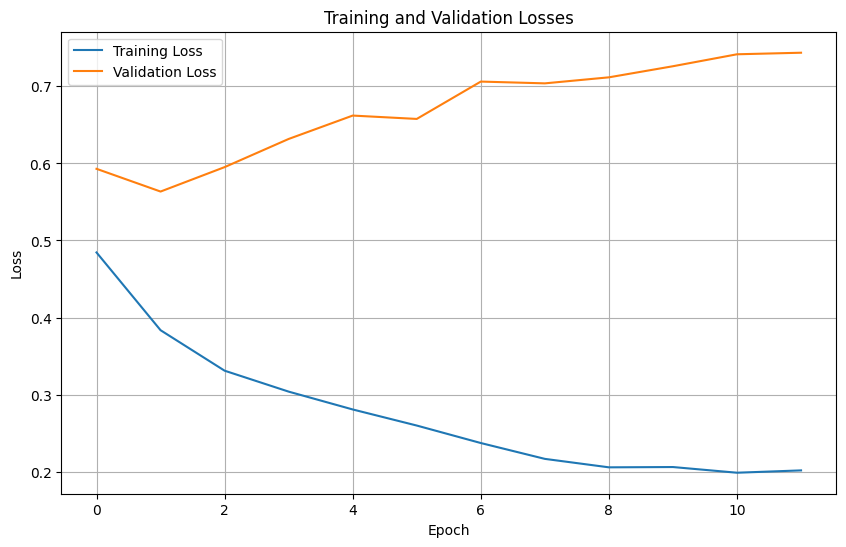

In [ ]:
# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Save the trained model
torch.save(model.state_dict(), '/content/drive/MyDrive/art_classification_model.pth')

In [ ]:
# Function to predict class for a single image
def predict_image(model, image_path, transform):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)

    classes = ['AI Baroque', 'AI Cubism', 'AI Expressionism',
               'Human Baroque', 'Human Cubism', 'Human Expressionism']
    return classes[predicted.item()]